In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision as tv
import torchvision.transforms as transforms
import time
import matplotlib.pyplot as plt

In [2]:
# Задаем устройство, на котором будем выполнять вычисления (CPU или GPU, если доступен)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

In [3]:
# 60_000 примеров по 256 шт = 235 батчей
BATCH_SIZE=256

train_dataset = tv.datasets.FashionMNIST('.', train=True, transform=tv.transforms.ToTensor(), download=True)
test_dataset = tv.datasets.FashionMNIST('.', train=False, transform=tv.transforms.ToTensor(), download=True)
trainloader = torch.utils.data.DataLoader(train_dataset, batch_size=BATCH_SIZE)
testloader = torch.utils.data.DataLoader(test_dataset, batch_size=BATCH_SIZE)

In [4]:
print(train_dataset.class_to_idx, train_dataset.data.shape, sep='\n\n')

{'T-shirt/top': 0, 'Trouser': 1, 'Pullover': 2, 'Dress': 3, 'Coat': 4, 'Sandal': 5, 'Shirt': 6, 'Sneaker': 7, 'Bag': 8, 'Ankle boot': 9}

torch.Size([60000, 28, 28])


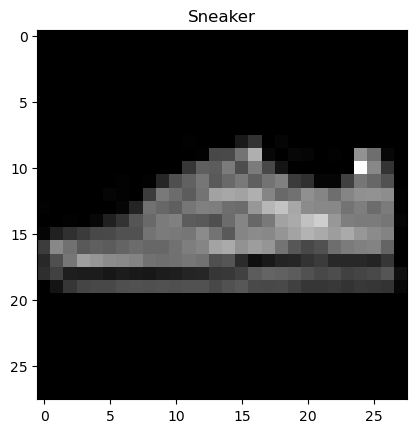

In [5]:
img = train_dataset[666]
plt.imshow(img[0].numpy().reshape(28,28), cmap='gray');
plt.title(tuple(train_dataset.class_to_idx.keys())[img[1]])
plt.show()

In [6]:
import torch
import torch.nn as nn

# Определяем архитектуру модели
class ConvNet(nn.Module):
    def __init__(self):
        super(ConvNet, self).__init__()

        self.conv1 = nn.Conv2d(1, 32, kernel_size=3, padding=1)
        self.bn1 = nn.BatchNorm2d(32)
        self.relu1 = nn.ReLU()
        self.pool1 = nn.MaxPool2d(2, 2)
        self.dropout1 = nn.Dropout2d(0.25)

        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.bn2 = nn.BatchNorm2d(64)
        self.relu2 = nn.ReLU()
        self.pool2 = nn.MaxPool2d(2, 2)
        self.dropout2 = nn.Dropout2d(0.25)

        self.conv3 = nn.Conv2d(64, 128, kernel_size=3, padding=1)
        self.bn3 = nn.BatchNorm2d(128)
        self.relu3 = nn.ReLU()
        self.pool3 = nn.MaxPool2d(2, 2)
        self.dropout3 = nn.Dropout2d(0.25)

        self.fc1 = nn.Linear(128 * 3 * 3, 128)
        self.bn4 = nn.BatchNorm1d(128)
        self.relu4 = nn.ReLU()
        self.dropout4 = nn.Dropout(0.5)

        self.fc2 = nn.Linear(128, 10)

    def forward(self, x):
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu1(x)
        x = self.pool1(x)
        x = self.dropout1(x)

        x = self.conv2(x)
        x = self.bn2(x)
        x = self.relu2(x)
        x = self.pool2(x)
        x = self.dropout2(x)

        x = self.conv3(x)
        x = self.bn3(x)
        x = self.relu3(x)
        x = self.pool3(x)
        x = self.dropout3(x)

        x = x.view(x.size(0), -1)

        x = self.fc1(x)
        x = self.bn4(x)
        x = self.relu4(x)
        x = self.dropout4(x)

        x = self.fc2(x)

        return x

In [7]:
# Инициализируем модель и отправляем ее на устройство
model = ConvNet().to(device)

# Определяем функцию потерь и оптимизатор
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

In [8]:
# Обучение модели
num_epochs = 15

for epoch in range(num_epochs):
    running_loss = 0.0
    start = time.perf_counter()
    for i, data in enumerate(trainloader):
        inputs, labels = data[0].to(device), data[1].to(device)
        
        optimizer.zero_grad()
        
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item()
        
        if (i+1) % 100 == 0:
            print(f"Epoch [{epoch+1}/{num_epochs}], Step [{i+1}/{len(trainloader)}], Loss: {running_loss/100:.4f}")
            running_loss = 0.0
    print(f'{time.perf_counter() - start:.1f} sec')
    

print("Training finished.")

Epoch [1/15], Step [100/235], Loss: 0.8755
Epoch [1/15], Step [200/235], Loss: 0.4973
11.0 sec
Epoch [2/15], Step [100/235], Loss: 0.4038
Epoch [2/15], Step [200/235], Loss: 0.3791
9.4 sec
Epoch [3/15], Step [100/235], Loss: 0.3493
Epoch [3/15], Step [200/235], Loss: 0.3325
9.2 sec
Epoch [4/15], Step [100/235], Loss: 0.3134
Epoch [4/15], Step [200/235], Loss: 0.3081
8.8 sec
Epoch [5/15], Step [100/235], Loss: 0.2909
Epoch [5/15], Step [200/235], Loss: 0.2861
8.5 sec
Epoch [6/15], Step [100/235], Loss: 0.2779
Epoch [6/15], Step [200/235], Loss: 0.2710
9.3 sec
Epoch [7/15], Step [100/235], Loss: 0.2639
Epoch [7/15], Step [200/235], Loss: 0.2678
9.2 sec
Epoch [8/15], Step [100/235], Loss: 0.2563
Epoch [8/15], Step [200/235], Loss: 0.2555
9.2 sec
Epoch [9/15], Step [100/235], Loss: 0.2477
Epoch [9/15], Step [200/235], Loss: 0.2422
9.3 sec
Epoch [10/15], Step [100/235], Loss: 0.2378
Epoch [10/15], Step [200/235], Loss: 0.2393
9.1 sec
Epoch [11/15], Step [100/235], Loss: 0.2311
Epoch [11/15]

In [9]:
# Оценка модели на тестовом наборе данных
correct = 0
total = 0

with torch.no_grad():
    for data in testloader:
        images, labels = data[0].to(device), data[1].to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

accuracy = 100 * correct / total
print(f"Accuracy on test set: {accuracy}%")

Accuracy on test set: 90.32%
